In [7]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser
import matplotlib.pylab as pylab
from cycler import cycler
import palettable

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [4]:
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/draft/plots/"

In [5]:
alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

In [6]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Sensitivity to compact objects

In [71]:
def get_f_DM_lim(M_DM=1e8*M_s, R0_DM=0, sigma_mu = 1, sigma_alpha = .1, N_q = 1e9, l_min_mu=10, l_max_mu=2000, l_min_alpha=10, l_max_alpha=2000):
    
    l_max = max(l_max_mu, l_max_alpha)
    
    pspecpop = PowerSpectraPopulations(l_max=l_max)
    pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=260*kpc)
    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
    
    Cl_ary = pspecpop.get_C_l_compact_total_ary()
    Cl_ary_accel = np.zeros(len(Cl_ary)) #pspecpop.get_C_l_compact_total_ary(accel=True)
        
    fDM_base = 0
    dfDM_base = 0.1

    Cl_ary_fid = np.array(Cl_ary)*fDM_base
    Cl_ary_accel_fid = np.array(Cl_ary_accel)*fDM_base

    p = np.array(Cl_ary)*(fDM_base + dfDM_base)
    m = np.array(Cl_ary)*(fDM_base - dfDM_base)

    p_a = np.array(Cl_ary_accel)*(fDM_base + dfDM_base)
    m_a = np.array(Cl_ary_accel)*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    p_a, m_a, '$\\f_\mathrm{DM}$' )

    parameters = [Cl_ary_fid, None, 1, l_max, fDM]
    
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=sigma_alpha, N_q=N_q, l_min_mu=l_min_mu, l_max_mu=l_max_mu, l_min_alpha=l_min_alpha, l_max_alpha=l_max_alpha)

    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])

    return lim, fshr

In [474]:
M_DM_ary = np.logspace(1.5,10,10)*M_s

f_DM_lim_1_ary = [get_f_DM_lim(M_DM, sigma_mu=1, sigma_alpha=.1, N_q=1e8, l_max_mu=2000, l_max_alpha=2000)[0] for M_DM in tqdm_notebook(M_DM_ary)]
f_DM_lim_2_ary = [get_f_DM_lim(M_DM, sigma_mu=1, sigma_alpha=.1, N_q=1e8,l_max_mu=10000,l_max_alpha=10000)[0] for M_DM in tqdm_notebook(M_DM_ary)]
f_DM_lim_3_ary = [get_f_DM_lim(M_DM, R0_DM=10*pc, sigma_mu=1, sigma_alpha=.1, N_q=1e8,l_max_mu=2000,l_max_alpha=2000)[0] for M_DM in tqdm_notebook(M_DM_ary)]


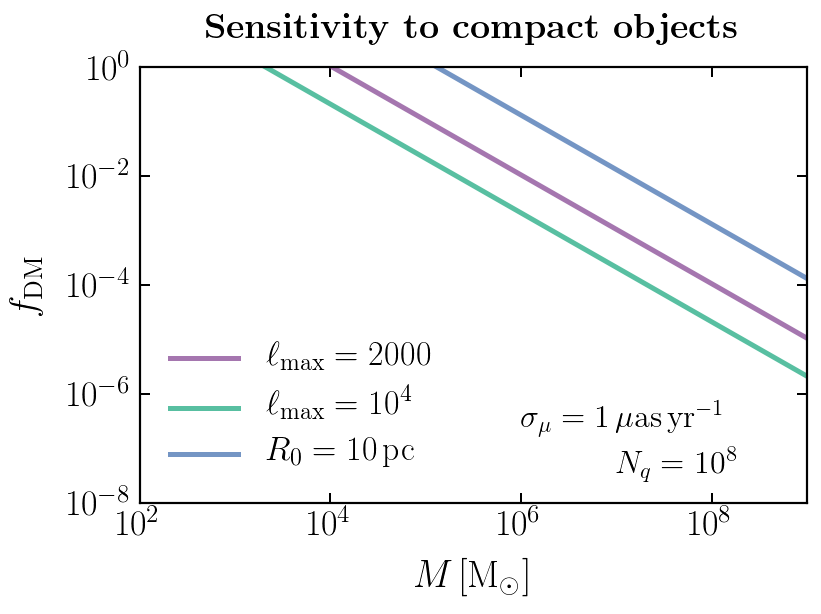

In [476]:
plt.plot(M_DM_ary/M_s, f_DM_lim_1_ary, label='$\ell_\mathrm{max} = 2000$')
plt.plot(M_DM_ary/M_s, f_DM_lim_2_ary, label='$\ell_\mathrm{max} = 10^4$')
plt.plot(M_DM_ary/M_s, f_DM_lim_3_ary, label='$R_0=10$\,pc')

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e-8,1)
plt.xlim(1e2,1e9)

plt.xlabel("$M$\,[M$_\odot$]")
plt.ylabel("$f_\mathrm{DM}$")

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.02, fontsize=18)
legend = plt.legend()
# plt.setp(legend.get_title(),fontsize=18)

plt.text(1e6, 2e-7, "$\sigma_\mu=1\,\mu$as\,yr$^{-1}$", fontsize=16)
plt.text(1e7, 3e-8, "$N_q = 10^8$", fontsize=16)

plt.tight_layout()
plt.savefig(plots_dir + "/compact.pdf")

In [478]:
R0_DM=0*pc
lim, fshr = get_f_DM_lim(M_DM=1e6*M_s, sigma_mu=1, R0_DM=R0_DM, sigma_alpha=.1, N_q=1e8, l_min_mu=1, l_max_mu=2000,l_min_alpha=1, l_max_alpha=2000) 

R0_DM=10*pc
lim1, fshr1 = get_f_DM_lim(M_DM=1e6*M_s, sigma_mu=1, R0_DM=R0_DM, sigma_alpha=.1, N_q=1e8, l_min_mu=1, l_max_mu=2000,l_min_alpha=1, l_max_alpha=2000) 

0.010576638294907676


0.1322648573424848


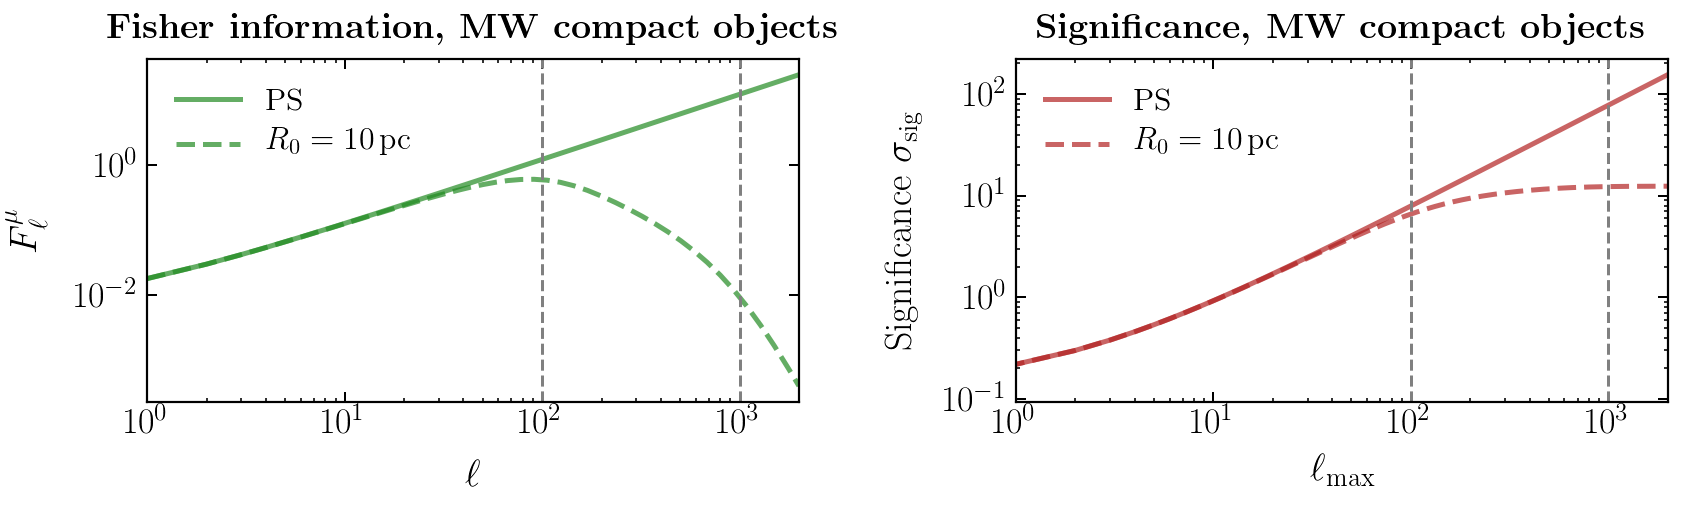

In [480]:
l_ary = np.arange(1,len(fshr.fshr_l[0,0]) + 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

ax1.plot(l_ary, fshr.fshr_l[0,0], color='forestgreen', label='PS')
ax1.plot(l_ary, fshr1.fshr_l[0,0], color='forestgreen',ls='--', label='$R_0=10$\,pc')
ax1.axvline(1 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
ax1.axvline(10 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
# ax1.text(10** (np.log10(0.5 * kpc / R_0) + .05 ), 5e-3, '$0.5\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)
# ax1.text(10** (np.log10(10 * kpc / R_0) + .05 ), 1e-4, '$10\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)

ax1.set_xlabel('$\ell$')
ax1.set_ylabel(r'$F_\ell^{\mu}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title(r"\textbf{Fisher information, MW compact objects}")
ax1.legend(fontsize=16)

ax1.set_xlim(min(l_ary), max(l_ary))

ax2.plot(np.sqrt(np.cumsum(fshr.fshr_l[0,0])), color='firebrick', label='PS')
ax2.plot(np.sqrt(np.cumsum(fshr1.fshr_l[0,0])), color='firebrick', ls='--', label='$R_0=10$\,pc')
ax2.axvline(1 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
ax2.axvline(10 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
# ax2.text(10** (np.log10(0.5 * kpc / R_0) + .05 ), 5e2, '$0.5\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)
# ax2.text(10** (np.log10(10 * kpc / R_0) + .05 ), 6, '$10\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)

ax2.set_xlabel('$\ell_\mathrm{max}$')
ax2.set_ylabel('Significance $\sigma_\mathrm{sig}$')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title(r"\textbf{Significance, MW compact objects}")
ax2.set_xlim(min(l_ary), max(l_ary))
ax2.legend(fontsize=16)

plt.tight_layout()

plt.savefig(plots_dir + "fisher_mu_mw.pdf")

In [72]:
M_ary = np.logspace(3,10,20) * M_s
R_ary = np.logspace(-4,4,20) * pc

In [73]:
sig_ary = np.zeros((len(M_ary), len(R_ary)))
lim_ary = np.zeros((len(M_ary), len(R_ary)))

for iM, M in enumerate(tqdm_notebook(M_ary)):
    for iR, R in enumerate(R_ary):
        lim_ary[iM, iR] = get_f_DM_lim(M, R0_DM=R, sigma_mu=1, sigma_alpha=.1, N_q=1e8, l_max_mu=2000, l_max_alpha=2000)[0]

../../theory/spec_calc.py:462: RuntimeWarning: divide by zero encountered in log10
  self.C_l_ary = 10 ** np.interp(np.log10(self.l_ary), np.log10(self.l_ary_calc), np.log10(C_l_calc_ary))


In [56]:
lim_R = []
for iM, M in enumerate((M_ary)):
    lim_R.append(interp1d(lim_ary[iM], R_ary, bounds_error=False, kind='linear', fill_value='extrapolate')(1.) / pc)

In [74]:
lim_R = []
for iM, M in enumerate((M_ary)):
    lim_R.append(np.interp(1, lim_ary[iM], R_ary) / pc)

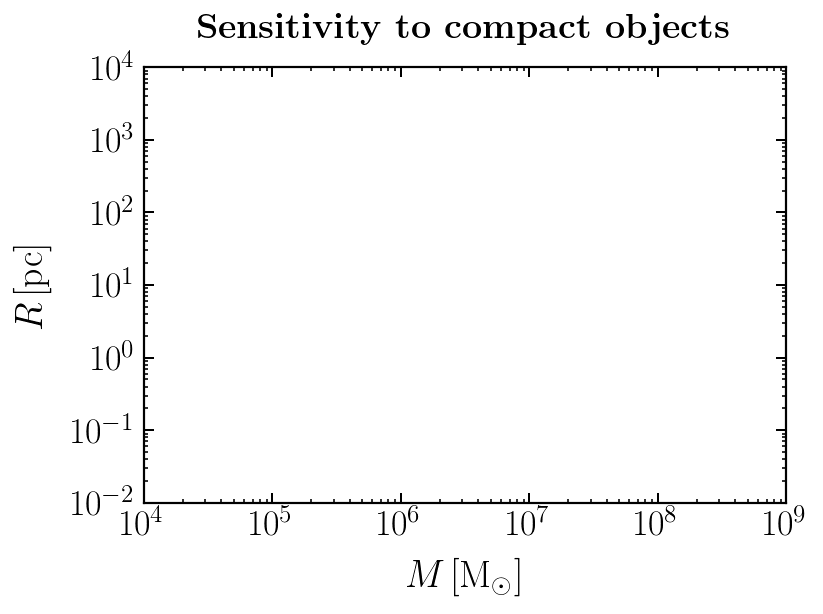

In [75]:
plt.plot(M_ary / M_s, np.array(lim_R))
plt.xscale("log")
plt.yscale("log")

plt.xlim(1e4,1e9)
plt.ylim(1e-2,1e4)

plt.xlabel("$M$\,[M$_\odot$]")
plt.ylabel("$R$\,[pc]")

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.02, fontsize=18)

plt.tight_layout()

# plt.savefig(plots_dir + "compact_M_vs_R.pdf")